# Prediction, confidence and reward weight estimation

**Analysis steps:**

1. [📓 Questionnaire processing.ipynb](Questionnaire%20processing.ipynb)
2. [📓 Factor analysis.ipynb](Factor%20analysis.ipynb)
3. ▶ **[📓 Prediction analysis.ipynb](Prediction%20analysis.ipynb)**
4. [📓 Prediction modelling.ipynb](Prediction%20modelling.ipynb)

This notebook performs analysis of subjects' predictions of the predator's movements, alongside their confidence in these predictions and their reward weight estimates.


## Imports


In [1]:
import os

import matplotlib
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, ttest_1samp
from stats_utils.regression.analysis import sequential_regression
from stats_utils.regression.plotting import forest_plot, plot_r2s

from interactive_avoidance.analysis import run_exploratory_models
from interactive_avoidance.data import (
    load_all_data,
    load_environment_data,
    load_factor_scores,
    scale_data,
    separate_predator_prey_data,
    sort_dataframes,
    process_ratings,
)
from interactive_avoidance.style import set_style
from interactive_avoidance.utils import (
    check_directories,
    print_demographics,
    dataframes_to_markdown,
    coefficients_to_dataframe,
)

# Check that we're in the right directory
check_directories()

set_style("style.mplstyle")

# Create a figure directory if it doesn't exist
if not os.path.isdir("figures"):
    os.mkdir("figures")

Changing directory to root directory of repository...
Font saved to: ./fonts
Matplotlib style set to: style.mplstyle with font Heebo


## Load in data


### Load in questionnaire data

Next we load in the factor scores and the summed scores for the questionnaires.


In [2]:
# Load in factor scores for all solutions
factor_scores = load_factor_scores(5)

# Load in questionnaire data
qdata = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)
n_qdata = len(qdata)

# Attention checks
qdata = qdata[qdata["attention_check_failed"] < 1]

# Excluding subjects who fail more than one infrequency item check.
qdata = qdata[qdata["inattentive_incorrect"] <= 1]

# we shouldn't have any duplicate rows, but just in case
qdata = qdata.drop_duplicates(["subjectID"])

print("\nDemographics for final analyses:")
print_demographics(
    qdata[qdata["subjectID"].isin(factor_scores["subjectID"])]
)  # Factor scores also exclude gender > 1

Dropped 7 subjects with gender != 0 or 1.

Demographics for final analyses:
Number of subjects = 989
Mean (SD) age = 36.24 (12.23)
Gender counts: 495 Male, 494 Female


### Task data

Here we use the `load_all_data` function to load in all the behavioural data from the task. We then tidy this up a little and check that it looks as it should.


In [3]:
# Load in all data
(
    rating_df,
    rt_prey_df,
    rt_predator_df,
    confidence_df,
    prediction_df,
    response_df,
) = load_all_data(questionnaire_data=qdata)

# Print demographics for subjects in task data
print("\nDemographics for subjects in task data:")
print_demographics(qdata[qdata["subjectID"].isin(prediction_df["subjectID"])])

# Separate predator an prey movements
prey_df, predator_df = separate_predator_prey_data(response_df)

# Sort dataframes to keep things tidy
prediction_df, predator_df, prey_df = sort_dataframes(
    [prediction_df, predator_df, prey_df]
)

# Check that everything looks as it should
assert np.all(
    prediction_df["subjectID"] == predator_df["subjectID"]
), "Subject ID columns do not match"
assert np.all(
    prediction_df["condition"] == predator_df["condition"]
), "Condition columns do not match"
assert np.all(
    prediction_df["trial"] == predator_df["trial"]
), "Trial columns do not match"
assert np.all(
    prediction_df["response_number"] == predator_df["response_number"]
), "Response number columns do not match"

Removed 20 subjects not present in questionnaire data.

Demographics for subjects in task data:
Number of subjects = 999
Mean (SD) age = 36.26 (12.28)
Gender counts: 497 Male, 493 Female, 4 Other, 3 Prefer not to say


### Task data

Here we use the `load_all_data` function to load in all the behavioural data from the task. We then tidy this up a little and check that it looks as it should.


In [4]:
# Load in all data
(
    rating_df,
    rt_prey_df,
    rt_predator_df,
    confidence_df,
    prediction_df,
    response_df,
) = load_all_data()

# Separate predator an prey movements
prey_df, predator_df = separate_predator_prey_data(response_df)

# Sort dataframes to keep things tidy
prediction_df, predator_df, prey_df = sort_dataframes(
    [prediction_df, predator_df, prey_df]
)

# Check that everything looks as it should
assert np.all(
    prediction_df["subjectID"] == predator_df["subjectID"]
), "Subject ID columns do not match"
assert np.all(
    prediction_df["condition"] == predator_df["condition"]
), "Condition columns do not match"
assert np.all(
    prediction_df["trial"] == predator_df["trial"]
), "Trial columns do not match"
assert np.all(
    prediction_df["response_number"] == predator_df["response_number"]
), "Response number columns do not match"

## Get proportion correct

We want to assess how accurate subjects' predictions of the predator's behaviour were. Here we calculate the proportion of correct predictions for each subject.


In [5]:
# Label predictions as correct or incorrect based on whether the predicted cellID matches the actual cellID
prediction_df["correct"] = predator_df["cellID"] == prediction_df["cellID"]

# Group the predictions by subjectID, condition, and response_number, then calculate the mean correctness for each group
predictions_correct = (
    prediction_df.groupby(["subjectID", "condition", "response_number"])
    .mean()
    .reset_index()[["subjectID", "correct", "condition", "response_number"]]
)

# Rename the 'correct' column to 'Proportion correct' for clarity
predictions_correct = predictions_correct.rename(
    columns={"correct": "Proportion correct"}
)

# Filter the data to only consider the first prediction
predictions_correct = predictions_correct[predictions_correct["response_number"] == 0]

# Rename the condition column
predictions_correct = predictions_correct.rename(
    columns={"condition": "Reward weights"}
)

# Display the first few rows of the resulting DataFrame
predictions_correct.head()

,subjectID,Proportion correct,Reward weights,response_number
0,subject001,0.50,cond1,0
2,subject002,0.40,cond1,0
4,subject003,0.65,cond1,0
6,subject004,0.65,cond1,0
8,subject005,0.55,cond1,0


### Plot the distribution

We can plot the distribution of proportion correct predictions across subjects as a density plot using the `kdeplot` function from `seaborn`.


(0.0, 1.0)

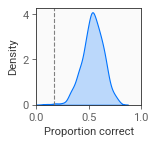

In [6]:
# Initialize a plot with specified size
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot a kernel density estimate (KDE) of the "Proportion correct" data
sns.kdeplot(predictions_correct, x="Proportion correct", fill=True, legend=False, ax=ax)

# Draw a vertical dashed line to represent the "guessing" level (1/6th)
ax.axvline(1 / 6.0, color="gray", linestyle="--")  # Guessing

# Set the x-axis limits to be between 0 and 1
ax.set_xlim(0, 1)

Then do t-tests to check that these proportions are significantly greater than chance (i.e. 1/6)


In [7]:
# Get the proportion correct data
pcorrect = predictions_correct["Proportion correct"].values

# Conduct a one-sample t-test comparing the proportion correct to a chance level of 1/6
t, p = ttest_1samp(pcorrect, 1 / 6)

# Calculate the effect size (Cohen's d) for the t-test
d = pg.compute_effsize_from_t(t, N=len(pcorrect), eftype="cohen")

# Print the results of the t-test and the effect size for the current condition
print(f"t({len(pcorrect) - 1}) = {t}, p = {p}, d={d}")

t(1018) = 114.27457483178607, p = 0.0, d=7.159661960152343


### Get reaction times

Next we get average reaction times for each subject when making predictions about the predator's behaviour.


In [8]:
# Get mean RT for each subject
rt_df = (
    rt_predator_df.drop(columns=["condition"])
    .groupby(["subjectID"])
    .mean()
    .reset_index()[["subjectID", "reactionTimePredatorData"]]
)

# Relabel the columns
rt_df.columns = ["subjectID", "RT"]

rt_df.head()

,subjectID,RT
0,subject001,3023.6625
1,subject002,1130.7125
2,subject003,1487.3500
3,subject004,1588.0875
4,subject005,1877.0000


### Merge dataframes

Next we merge the prediction data with our mental health measures so that we can see if there are any relationships between these variables.


In [9]:
# Merge in questionnaire data
predictions_correct_mh_measures = pd.merge(
    predictions_correct, factor_scores, on="subjectID"
)
predictions_correct_mh_measures = pd.merge(
    predictions_correct_mh_measures, rt_df, on="subjectID"
)
predictions_correct_mh_measures = pd.merge(
    predictions_correct_mh_measures,
    qdata.drop(columns=["age", "gender"]),
    on="subjectID",
)

# Keep the raw p_correct for later
predictions_correct_mh_measures["p_correct_raw"] = predictions_correct_mh_measures[
    "Proportion correct"
]

# Scale data
for col in predictions_correct_mh_measures.columns:
    if col not in ["subjectID", "gender", "Reward weights", "study", "p_correct_raw"]:
        predictions_correct_mh_measures[col] = (
            predictions_correct_mh_measures[col]
            - predictions_correct_mh_measures[col].mean()
        ) / predictions_correct_mh_measures[col].std()


# Give the dependent variable a nicer name
predictions_correct_mh_measures["p_correct"] = predictions_correct_mh_measures[
    "Proportion correct"
]

## Sequential regression models

### Model fitting

We use a sequential regression modelling approach (also sometimes called "hierarchical" regression, but that has multiple meanings) to understand whether behaviour on the task is related to broad or specific dimensions of mental health symptoms. We start by predicting task behaviour from simpler factor solutions, and then add in more complex factor solutions to see if they explain any additional variance.


[0.04172221724599279, 0.04270160147837321, 0.04230787451752849, 0.04301957342634688, 0.06095406569547779]


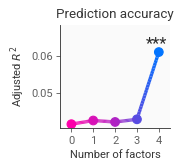

In [10]:
# Run sequential regression
predictions_correct_model_outputs = sequential_regression(
    predictions_correct_mh_measures,
    "p_correct",
    n_solutions=4,
    covariates=["motivation"],
    n_bootstraps=20000,
)

# Plot the results
plot_r2s(predictions_correct_model_outputs)
sns.despine()

# Print the R2s
print(predictions_correct_model_outputs.r2s)

# Set title
plt.title("Prediction accuracy")

# Save figure
plt.savefig("figures/prediction_accuracy.svg")

In [11]:
predictions_correct_model_outputs_anova = (
    predictions_correct_model_outputs.anova_results[
        ["df_resid", "ssr", "ss_diff", "F", "Pr(>F)"]
    ]
)
predictions_correct_model_outputs_anova.round(
    {
        "df_resid": 0,
        "ssr": 2,
        "ss_diff": 2,
        "F": 2,
        "Pr(>F)": 3,
    }
)

,df_resid,ssr,ss_diff,F,Pr(>F)
0,979.0,938.15,NaN,NaN,NaN
1,978.0,936.24,1.92,2.04,0.153
2,977.0,935.67,0.57,0.61,0.435
3,976.0,934.01,1.65,1.76,0.185
4,975.0,915.57,18.44,19.64,0.000


### Plot the coefficients

Here we take the coefficient from the model that explained the most variance and plot them.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              p_correct   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     10.11
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           3.01e-12
Time:                        14:49:18   Log-Likelihood:                -1359.9
No. Observations:                 983   AIC:                             2736.
Df Residuals:                     975   BIC:                             2775.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1211      0.047      2.589      0.010       0.029       0.213
age           -0.1582      0.033     -4.809      0.000      -0.223      -0.094
gender        -0.2419      0.070     -3.450      0.001      -0.379      -0.104
motivation     0.0808      0.031      2.597      0.010       0.020       0.142
Sol4_ML1      -0.0735      0.035     -2.080      0.038      -0.143      -0.004
Sol4_ML2      -0.0761      0.042     -1.805      0.071      -0.159       0.007
Sol4_ML3      -0.0224      0.039     -0.583      0.560      -0.098       0.053
Sol4_ML4       0.1932      0.040      4.823      0.000       0.115       0.272
==============================================================================
Omnibus:                       20.453   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.983
Skew:                          -0.294   Prob(JB):                     1.02e-05
Kurtosis:                       3.463   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

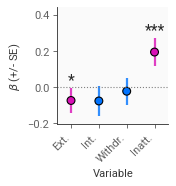

In [12]:
rename_dict = {
    "Sol4_ML1": "Ext.",
    "Sol4_ML2": "Int.",
    "Sol4_ML3": "Withdr.",
    "Sol4_ML4": "Inatt.",
}

forest_plot(
    predictions_correct_model_outputs.models[4],
    rename_dict=rename_dict,
    exclude_param_names=["age", "gender", "motivation"],
)

# Print the summary
predictions_correct_model_outputs.models[4].summary()

# Save figure
# plt.savefig("figures/prediction_accuracy_forest.svg", bbox_inches="tight")

### Exploratory analyses of other measures

We have a few other measures that maight be of interest to explore. Here we do some exploratory analyses to see if there are any relationships between these measures and task behaviour.


In [13]:
predictions_correct_exploratory = run_exploratory_models(
    ["p_correct"], predictions_correct_mh_measures
)
predictions_correct_exploratory

,parameter,measure,t,df,p,p_fdr
0,p_correct,AQ_10,0.411594,978.0,0.724,0.995
1,p_correct,STICSA_T,1.553916,978.0,0.119,0.595
2,p_correct,LSAS,0.029642,978.0,0.995,0.995
3,p_correct,PHQ_8,0.795388,606.0,0.390,0.975
4,p_correct,GAD_7,0.005003,605.0,0.987,0.995


## Reaction times

We further look at the relationship between reaction times when making predictions about the predator and symptom dimensions.


[0.014652788390405513, 0.014078509064749611, 0.013136784978435845, 0.012127422342224081, 0.012593479281702069]


Text(0.5, 1.0, 'RT')

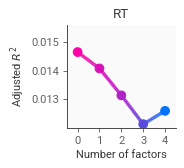

In [14]:
# Run sequential regression
predictions_rt_model_outputs = sequential_regression(
    predictions_correct_mh_measures,
    "RT",
    n_solutions=4,
    covariates=["motivation"],
    n_bootstraps=20000,
)

# Plot the results
plot_r2s(predictions_rt_model_outputs)
sns.despine()

# Print the R2s
print(predictions_rt_model_outputs.r2s)

# Set title
plt.title("RT")

# Save figure
# plt.savefig("figures/prediction_accuracy.svg")

In [15]:
predictions_rt_model_outputs_anova = predictions_rt_model_outputs.anova_results[
    ["df_resid", "ssr", "ss_diff", "F", "Pr(>F)"]
]
predictions_rt_model_outputs_anova.round(
    {
        "df_resid": 0,
        "ssr": 2,
        "ss_diff": 2,
        "F": 2,
        "Pr(>F)": 3,
    }
)

,df_resid,ssr,ss_diff,F,Pr(>F)
0,979.0,964.65,NaN,NaN,NaN
1,978.0,964.23,0.42,0.43,0.513
2,977.0,964.17,0.07,0.07,0.796
3,976.0,964.16,0.00,0.00,0.967
4,975.0,962.72,1.44,1.46,0.227


## Confidence in predictions

Next we look at how confident participants were in their predictions.

### Organise the data


In [16]:
# Group the confidence_df by 'subjectID' and calculate the mean for each subject
confidence_summary = (
    confidence_df.drop(columns=["condition"])
    .groupby(["subjectID"])
    .mean()
    .reset_index()
)

# Merge the summarized confidence data with the factor_scores DataFrame based on the 'subjectID' column
confidence_summary_mh_measures = pd.merge(
    confidence_summary, factor_scores.drop(columns=["study"]), on="subjectID"
)

# Merge the combined data with qdata, excluding 'age' and 'gender' columns, based on the 'subjectID' column
confidence_summary_mh_measures = pd.merge(
    confidence_summary_mh_measures,
    qdata.drop(columns=["age", "gender"]),
    on="subjectID",
)

# Scale the data using the previously defined scale_data function
# confidence_summary_mh_measures = scale_data(confidence_summary_mh_measures)
# Scale columns to have 0 mean and 1 SD without using scale_data
for col in confidence_summary_mh_measures.columns:
    if col not in ["subjectID", "gender"]:
        confidence_summary_mh_measures[col] = (
            confidence_summary_mh_measures[col]
            - confidence_summary_mh_measures[col].mean()
        ) / confidence_summary_mh_measures[col].std()


# Merge the scaled data with predictions_correct_mh_measures DataFrame, specifically the 'subjectID' and 'p_correct' columns
confidence_summary_mh_measures = pd.merge(
    confidence_summary_mh_measures,
    predictions_correct_mh_measures[["subjectID", "p_correct"]],
    on="subjectID",
)

# merge prediction and confidence data
prediction_confidence = pd.merge(
    predictions_correct_mh_measures,
    confidence_summary_mh_measures[["subjectID", "confidence"]],
    on="subjectID",
)

# merge RT data
prediction_confidence = pd.merge(
    prediction_confidence,
    rt_df,
    on="subjectID",
)

# Create output directory if it doesn't exist
if not os.path.isdir("results/task/predict"):
    os.makedirs("results/task/predict")

# save to csv
prediction_confidence.to_csv("results/task/prediction_confidence.csv", index=False)

### Plot the distribution


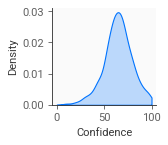

In [17]:
# Create a new figure and axis with the specified size
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot a kernel density estimate of the 'confidence' column of the confidence_summary DataFrame
sns.kdeplot(
    confidence_summary, x="confidence", fill=True, legend=False, clip=[0, 100], ax=ax
)

# Set the x-axis label for the plot
ax.set_xlabel("Confidence")

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

### Run sequential regression models


[0.10377547936023035, 0.10583186751150708, 0.11782980684367217, 0.12034730486667022, 0.1356177821483786]


Text(0.5, 1.0, 'Prediction confidence')

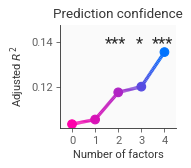

In [18]:
# Run a sequential regression model to predict confidence from mental health measures
confidence_model_outputs = sequential_regression(
    confidence_summary_mh_measures,
    "confidence",
    n_solutions=4,
    covariates=(["p_correct", "motivation"]),
    n_bootstraps=20000,
)

# Plot the R-squared values for each model in the sequence
plot_r2s(confidence_model_outputs)

# Print the R2s
print(confidence_model_outputs.r2s)

# Remove the top and right spines from the plot for a cleaner look
sns.despine()

# Adjust title
plt.title("Prediction confidence")

# Save
# plt.savefig("figures/prediction_confidence.svg")

In [19]:
confidence_model_outputs_anova = confidence_model_outputs.anova_results[
    ["df_resid", "ssr", "ss_diff", "F", "Pr(>F)"]
]
confidence_model_outputs_anova.round(
    {
        "df_resid": 0,
        "ssr": 2,
        "ss_diff": 2,
        "F": 2,
        "Pr(>F)": 3,
    }
)

,df_resid,ssr,ss_diff,F,Pr(>F)
0,978.0,876.51,NaN,NaN,NaN
1,977.0,873.60,2.91,3.36,0.067
2,976.0,861.00,12.60,14.58,0.000
3,975.0,857.66,3.34,3.86,0.050
4,974.0,841.91,15.75,18.22,0.000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             confidence   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     20.26
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.64e-28
Time:                        14:51:28   Log-Likelihood:                -1318.7
No. Observations:                 983   AIC:                             2655.
Df Residuals:                     974   BIC:                             2699.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0724      0.045      1.609      0.108      -0.016       0.161
age           -0.0006      0.032     -0.018      0.986      -0.063       0.062
gender        -0.1447      0.068     -2.139      0.033      -0.278      -0.012
p_correct      0.1708      0.031      5.559      0.000       0.111       0.231
motivation     0.2365      0.030      7.894      0.000       0.178       0.295
Sol4_ML1       0.1312      0.034      3.862      0.000       0.065       0.198
Sol4_ML2       0.1153      0.041      2.843      0.005       0.036       0.195
Sol4_ML3      -0.1240      0.037     -3.356      0.001      -0.197      -0.051
Sol4_ML4      -0.1373      0.039     -3.531      0.000      -0.214      -0.061
==============================================================================
Omnibus:                       23.254   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.355
Skew:                          -0.290   Prob(JB):                     6.96e-07
Kurtosis:                       3.596   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

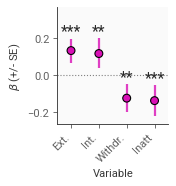

In [20]:
rename_dict = {
    "Sol4_ML1": "Ext.",
    "Sol4_ML2": "Int.",
    "Sol4_ML3": "Withdr.",
    "Sol4_ML4": "Inatt",
    "p_correct": "Pred. acc.",
}

forest_plot(
    confidence_model_outputs.models[4],
    rename_dict=rename_dict,
    exclude_param_names=["age", "gender", "motivation", "p_correct"],
)

# Save
plt.savefig("figures/prediction_confidence_forest.svg", bbox_inches="tight")

# Print the summary
confidence_model_outputs.models[4].summary()

### Exploratory analyses


In [21]:
confidence_summary_mh_measures["error_abs"] = confidence_summary_mh_measures[
    "p_correct"
]
confidence_correct_exploratory = run_exploratory_models(
    ["confidence"], confidence_summary_mh_measures
)
confidence_correct_exploratory

,parameter,measure,t,df,p,p_fdr
0,confidence,AQ_10,3.362350,977.0,0.001,0.0025
1,confidence,STICSA_T,-1.652935,977.0,0.100,0.1250
2,confidence,LSAS,-3.550737,977.0,0.000,0.0000
3,confidence,PHQ_8,-2.451348,605.0,0.021,0.0350
4,confidence,GAD_7,-1.463875,604.0,0.170,0.1700


### Plot relationship between confidence and accuracy


r = 0.1843229041528119, p = 5.827204750649278e-09


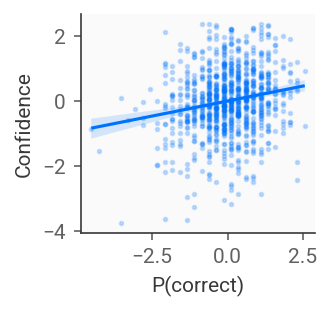

In [22]:
f, ax = plt.subplots(1, 1, figsize=(1.8, 1.8), dpi=150)
sns.regplot(
    x="p_correct",
    y="confidence",
    data=prediction_confidence,
    scatter_kws={"alpha": 0.2, "s": 3},
)

# make axis tick font regular weight
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")

plt.xlabel("P(correct)")
plt.ylabel("Confidence")

sns.despine()

# Calculate correlation
corr, p = pearsonr(
    prediction_confidence["p_correct"], prediction_confidence["confidence"]
)
print("r = {0}, p = {1}".format(corr, p))

## Ratings

Next we look at subjects' ratings of the predator's preferences.

### Organise the data


In [23]:
(
    rating_df_cleaned,
    rating_confidence_df,
    prey_ratings_mean_df,
    rating_confidence_mean_df,
) = process_ratings(rating_df)

### Get accuracy


In [24]:
print(
    "Accuracy: t({0}) = {1}, p = {2}, d={3}".format(
        len(pcorrect) - 1,
        t,
        p,
        pg.compute_effsize_from_t(t, N=len(pcorrect), eftype="cohen"),
    )
)

Accuracy: t(1018) = 114.27457483178607, p = 5.827204750649278e-09, d=7.159661960152343


### Plot average ratings


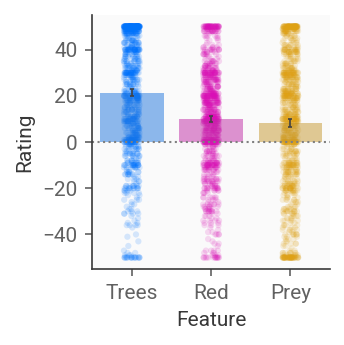

In [25]:
# Create a figure and axis with specified dimensions
f, ax = plt.subplots(1, 1, figsize=(2.4, 2.4), dpi=150)

# Add a horizontal line at y=0 for reference
ax.axhline(0, color="gray", linestyle=":")

# Filter the data to only consider environment 5 and exclude 'Confidence' feature
filtered_data = rating_df_cleaned[
    (rating_df_cleaned["env"] == 5) & (rating_df_cleaned["feature"] != "Confidence")
]

# Define a consistent order for the features
feature_order = ["Trees", "Red", "Prey"]

# Plot individual data points using a strip plot
sns.stripplot(
    x="feature",
    y="Rating",
    hue="feature",
    data=filtered_data,
    alpha=0.15,  # Making points slightly transparent
    ax=ax,
    zorder=-1,  # Put behind the bar plot
    hue_order=feature_order,
    order=feature_order,
    legend=False,
    s=3,  # Make points smaller
)

# Plot the average (and error bars) for each feature using a bar plot
sns.barplot(
    x="feature",
    y="Rating",
    hue="feature",
    data=filtered_data,
    alpha=0.5,  # Making bars slightly transparent
    capsize=0.05,  # Cap size for error bars
    errwidth=0.8,  # Width of error bars
    ax=ax,
    hue_order=feature_order,
    order=feature_order,
    dodge=False,  # Avoid bars being placed side-by-side
)

# Remove top and right spines for aesthetics
sns.despine()

# Remove the legend since it's redundant
plt.legend().set_visible(False)

# Set the x-axis label
plt.xlabel("Feature")

# Ensure the layout is tight so no elements overlap
plt.tight_layout()

# Save
# plt.savefig('../../figures/Figure-2_subject_reward_weight_predictions.svg')

### Combine with questionnaire data


In [26]:
# Group and average the cleaned ratings data by subject ID
preference_error_mh_measures = (
    rating_df_cleaned[rating_df_cleaned["env"] == 5]
    .groupby(["subjectID"])
    .mean(numeric_only=True)
    .reset_index()
)

# Merge the averaged ratings with factor scores based on subject ID
preference_error_mh_measures = pd.merge(
    preference_error_mh_measures, factor_scores, on="subjectID"
)

# Merge with qdata, dropping the 'age' and 'gender' columns, based on subject ID
preference_error_mh_measures = pd.merge(
    preference_error_mh_measures, qdata.drop(columns=["age", "gender"]), on="subjectID"
)

# Get absolute preference ratings
preference_error_mh_measures["Rating_abs"] = (
    preference_error_mh_measures["Rating"] - 50
).abs()
preference_error_mh_measures["Rating2"] = (
    preference_error_mh_measures["Rating"] - 50
) ** 2

# Store version before scaling
preference_error_mh_measures_raw = preference_error_mh_measures.copy()

# Scale the combined dataframe using the provided scale_data function
preference_error_mh_measures = scale_data(preference_error_mh_measures)

# Merge the scaled dataframe with prey ratings, based on subject ID
preference_error_mh_measures = pd.merge(
    preference_error_mh_measures,
    prey_ratings_mean_df[["subjectID", "prey_rating"]],
    on="subjectID",
)

# Merge the updated dataframe with confidence mean ratings, based on subject ID
preference_error_mh_measures = pd.merge(
    preference_error_mh_measures,
    rating_confidence_mean_df[["subjectID", "confidence", "confidence_var"]],
    on="subjectID",
)

/mnt/c/Users/tobyw/OneDrive-KCL/projects/interactive_avoidance_mh/TIDIED/interactive_avoidance_mh/interactive_avoidance/data.py:242: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[c] = (df[c] - df[c].mean()) / df[c].std()
/mnt/c/Users/tobyw/OneDrive-KCL/projects/interactive_avoidance_mh/TIDIED/interactive_avoidance_mh/interactive_avoidance/data.py:242: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[c] = (df[c] - df[c].mean()) / df[c].std()


### Plot relationship between confidence and error


r = 0.13032750230409731, p = 4.159641536677379e-05


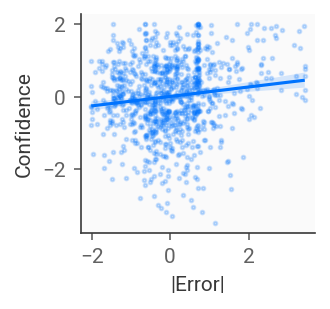

In [27]:
# Initialize a figure and axis with specified dimensions and resolution
f, ax = plt.subplots(1, 1, figsize=(1.8, 1.8), dpi=150)

# Plot a regression plot of absolute error against confidence
sns.regplot(
    x="error_abs",
    y="confidence",
    data=preference_error_mh_measures,
    scatter_kws={"alpha": 0.2, "s": 3},  # Adjusting appearance of scatter points
)

# Adjust axis tick font weights to be regular for better clarity
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")

# Label x and y axes
plt.xlabel("|Error|")
plt.ylabel("Confidence")

# Remove top and right borders for a cleaner look
sns.despine()

# Calculate and print the Pearson correlation between absolute error and confidence
corr, p = pearsonr(
    preference_error_mh_measures["error_abs"],
    preference_error_mh_measures["confidence"],
)
print("r = {0}, p = {1}".format(corr, p))

### Explore this in a bit more detail

It's a little odd to see a positive relationship between error and confidence, so let's explore this in a bit more detail. One possibility is that more extreme ratings (which are also _in general_ more likely to be wrong given 2 of the features have a preference of `0`) attract greater confidence ratings.

First we create a dataframe that allows us to look at the relationship between confidence and error for each feature.


In [28]:
# Filter out rows where 'env' column is not equal to 0
filtered_df = rating_df[rating_df["env"] != 0]

# Select only the specified columns from the filtered dataframe
df = filtered_df[["subjectID", "env", "rating", "feature"]]

# Convert the dataframe from long format to wide format
# The 'feature' column becomes new columns, and 'rating' values are placed accordingly
df_wide = df.pivot(
    index=["subjectID", "env"], columns="feature", values="rating"
).reset_index()

# Merge the original dataframe (excluding 'confidence' feature)
# with the 'confidence' column from the wide format dataframe
# The merge is based on 'subjectID' and 'env' columns
df_merged = pd.merge(
    df[df["feature"] != "confidence"],
    df_wide[["subjectID", "env", "confidence"]],
    on=["subjectID", "env"],
)

Next, we run regression models exploring the link between rating and confidence across the three features.


In [29]:
# The goal is to statistically test if there's a nonlinear (quadratic) relationship
# between ratings and confidence for each unique feature.

# Iterate over each unique feature value in the dataframe
for feature in df_merged["feature"].unique():
    # Filter the dataframe to only include rows corresponding to the current feature
    feature_df = df_merged[df_merged["feature"] == feature].copy()

    # Select only env == 5
    feature_df = feature_df[feature_df["env"] == 5]

    # Get absolute error
    true_rating = 50 if feature == "trees" else 0
    feature_df["error_abs"] = ((feature_df["rating"] - 50) - true_rating).abs()

    # Compute the squared value of the 'rating' column
    # to represent the quadratic term in the regression equation
    feature_df["rating2"] = (feature_df["rating"] - 50) ** 2

    # Perform a linear regression where the dependent variable is 'confidence',
    # and the independent variables are 'rating' and its squared term 'rating2'
    result = pg.linear_regression(
        X=feature_df[["rating", "rating2", "error_abs"]],
        y=feature_df["confidence"],
    )

    # Display the regression results for the current feature
    print(f"Feature: {feature}")
    print(result.round(2))

Feature: prey
       names   coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  68.37  2.04  33.43  0.00  0.13    0.13     64.36      72.38
1     rating  -0.09  0.02  -4.06  0.00  0.13    0.13     -0.14      -0.05
2    rating2   0.01  0.00   2.54  0.01  0.13    0.13      0.00       0.01
3  error_abs   0.09  0.16   0.58  0.56  0.13    0.13     -0.22       0.40
Feature: red
       names   coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  69.04  2.25  30.73  0.00  0.06    0.06     64.63      73.45
1     rating  -0.01  0.03  -0.41  0.68  0.06    0.06     -0.07       0.05
2    rating2   0.01  0.00   2.98  0.00  0.06    0.06      0.00       0.02
3  error_abs  -0.10  0.16  -0.64  0.52  0.06    0.06     -0.42       0.21
Feature: trees
       names  coef    se      T  pval    r2  adj_r2  CI[2.5%]  CI[97.5%]
0  Intercept  0.01  0.00  65.08   0.0  0.22    0.22      0.01       0.01
1     rating  0.60  0.02  35.09   0.0  0.22    0.22      0.57       0.64

/home/tobywise/.local/lib/python3.8/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 3 with 4 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


These seem to show that both the linear and quadratic terms are significant for all three features. This suggests that confidence ratings are higher for more extreme ratings, whether positive or negative, although there is a bias towards higher confidence ratings for higher preference ratings.

We can plot this using the `lmplot` function from `seaborn` to display the non-linear relationship between confidence and ratings more clearly.


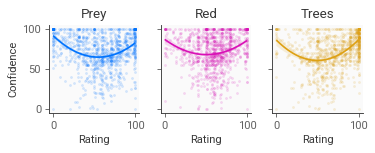

In [30]:
# Create a scatter plot with regression lines
# Each unique value in the 'feature' column will have its own subplot (faceted by the 'feature' column)
# Regression lines are polynomial of order 2
sns.lmplot(
    data=df_merged[df_merged["env"] == 5],  # Data source
    x="rating",  # x-axis variable
    y="confidence",  # y-axis variable
    col="feature",  # Column-wise facet variable
    order=2,  # Polynomial order for regression line
    col_wrap=3,  # Wrap the facet after every 3 plots
    scatter_kws={"alpha": 0.1, "s": 3},  # Custom scatter plot appearance
    hue="feature",  # Color by feature
    height=2,  # Height of each facet
    aspect=0.8,  # Aspect ratio of each facet
).set_titles(
    "{col_name}"
)  # Set title for each subplot based on the facet's column name

# Post-processing to capitalize titles and labels for each subplot
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title().capitalize())  # Capitalize subplot title
    ax.set_xlabel(ax.get_xlabel().capitalize())  # Capitalize x-axis label
    ax.set_ylabel(ax.get_ylabel().capitalize())  # Capitalize y-axis label

We can now look again at the relationship between absolute error and confidence, controlling for how extreme the ratings are.


Partial correlation (r) = 0.19561115927607495, p-value = 6.210057020694306e-10


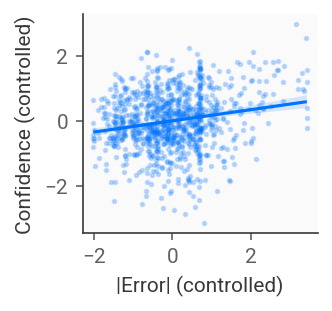

In [31]:
# Predict confidence from rating and rating_abs using statsmodels formula
model = smf.ols(
    formula="confidence ~ Rating + Rating2", data=preference_error_mh_measures
).fit()

# Get residuals
confidence_resid = model.resid

# Create a DataFrame with these residuals
residual_df = pd.DataFrame(
    {
        "error_abs": preference_error_mh_measures["error_abs"],
        "confidence_resid": confidence_resid,
    }
)

# Plot the residuals against each other
f, ax = plt.subplots(1, 1, figsize=(1.8, 1.8), dpi=150)
sns.regplot(
    x="error_abs",
    y="confidence_resid",
    data=residual_df,
    scatter_kws={"alpha": 0.2, "s": 3},
    ax=ax,
)

# Adjust axis tick font weights for better clarity
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight("regular")

# Label x and y axes
plt.xlabel("|Error| (controlled)")
plt.ylabel("Confidence (controlled)")

# Remove top and right borders for a cleaner look
sns.despine()

# Calculate and print the Pearson correlation between the residuals
corr, p = pearsonr(preference_error_mh_measures["error_abs"], confidence_resid)
print("Partial correlation (r) = {0}, p-value = {1}".format(corr, p))

### Run sequential regression models


In [32]:
# List of parameters for which we wish to run sequential regressions
parameter_names = ["confidence", "error_abs", "prey_rating"]

# Create an empty dictionary to store the outputs of each regression model
preference_rating_model_outputs = {}

# Loop over each parameter and run sequential regression
for p in parameter_names:
    # If the parameter is 'confidence', we control for 'error_abs' as a covariate
    if p == "confidence":
        preference_rating_model_outputs[p] = sequential_regression(
            preference_error_mh_measures,  # Data
            p,  # Current parameter
            n_solutions=4,  # Number of solutions
            covariates=[
                "error_abs",
                "Rating",
                "Rating2",
                "motivation",
            ],  # List of covariates
            n_bootstraps=20000,
        )
    # For other parameters, we do not control for any covariates
    else:
        preference_rating_model_outputs[p] = sequential_regression(
            preference_error_mh_measures,  # Data
            p,  # Current parameter
            n_solutions=4,  # Number of solutions
            covariates=["motivation"],
            n_bootstraps=20000,
        )

confidence
[0.32, 0.32, 0.33, 0.33, 0.34]
error_abs
[0.0, 0.0, 0.0, 0.0, 0.01]
prey_rating
[0.01, 0.01, 0.01, 0.01, 0.01]


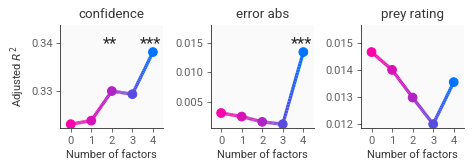

In [33]:
# Create a figure with one subplot for each parameter
f, ax = plt.subplots(1, len(parameter_names), figsize=(6, 2.2))

# Loop over each parameter and plot R-squared values from the regression outputs
for i, p in enumerate(parameter_names):
    # Print parameter name
    print(p)

    # Call a function `plot_r2s` to plot the R-squared values
    plot_r2s(
        preference_rating_model_outputs[p],  # Regression outputs for current parameter
        ax=ax[i],  # Current axis
        show_ylabel=i == 0,  # Show y-label only for the first subplot
    )
    sns.despine()  # Remove the top and right spines for aesthetics

    # Print the R2s
    print([np.round(i, 2) for i in preference_rating_model_outputs[p].r2s])

plt.tight_layout()  # Ensure subplots fit within the figure area

In [34]:
preference_rating_model_outputs_anova = {}

for v in preference_rating_model_outputs.keys():
    preference_rating_model_outputs_anova[v] = preference_rating_model_outputs[
        v
    ].anova_results[["df_resid", "ssr", "ss_diff", "F", "Pr(>F)"]]
    print(v)
    print(
        preference_rating_model_outputs_anova[v].round(
            {
                "df_resid": 0,
                "ssr": 2,
                "ss_diff": 2,
                "F": 2,
                "Pr(>F)": 3,
            }
        )
    )

confidence
   df_resid     ssr  ss_diff      F  Pr(>F)
0     976.0  667.85      NaN    NaN     NaN
1     975.0  666.43     1.42   2.12   0.146
2     974.0  659.64     6.79  10.15   0.001
3     973.0  659.61     0.03   0.04   0.833
4     972.0  650.25     9.36  13.99   0.000
error_abs
   df_resid     ssr  ss_diff      F  Pr(>F)
0     979.0  975.87      NaN    NaN     NaN
1     978.0  975.45     0.41   0.42   0.517
2     977.0  975.32     0.13   0.13   0.717
3     976.0  974.70     0.62   0.63   0.428
4     975.0  961.92    12.78  12.95   0.000
prey_rating
   df_resid     ssr  ss_diff     F  Pr(>F)
0     979.0  981.33      NaN   NaN     NaN
1     978.0  980.99     0.35  0.35   0.556
2     977.0  981.00    -0.02 -0.02   1.000
3     976.0  980.98     0.03  0.03   0.873
4     975.0  978.43     2.55  2.54   0.111


----------------------
error_abs
                            OLS Regression Results                            
Dep. Variable:              error_abs   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.907
Date:                Mon, 08 Jan 2024   Prob (F-statistic):            0.00517
Time:                        14:55:18   Log-Likelihood:                -1384.2
No. Observations:                 983   AIC:                             2784.
Df Residuals:                     975   BIC:                             2823.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.03

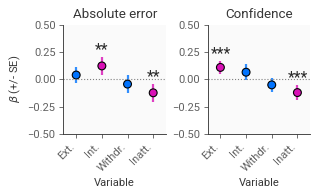

In [35]:
# Dictionary for more readable names
param_display_names = ["Absolute error", "Confidence"]

# Dictionary to map factor names to informative names
factor_name_dict = {
    "Sol3_ML1": "Int.",
    "Sol3_ML2": "Ext.",
    "Sol3_ML3": "Inatt.",
    "Sol4_ML1": "Ext.",
    "Sol4_ML2": "Int.",
    "Sol4_ML3": "Withdr.",
    "Sol4_ML4": "Inatt.",
    "error_abs": "|Error|",
}

# Create a figure with multiple subplots; width varies based on the parameter
f, ax = plt.subplots(
    1,
    len(parameter_names) - 1,
    figsize=(2 * len(parameter_names[:-1]), 2.55),
    gridspec_kw={"width_ratios": [2, 2]},
)

# Loop over each parameter to plot its regression outputs
for i, p in enumerate(parameter_names[:-1][::-1]):
    # Determine if there's a significant change in R-squared for any model
    r2_change = preference_rating_model_outputs[p].anova_results["Pr(>F)"] < 0.05

    # If any model shows significant R-squared change, use the last significant model
    # Otherwise, use the first model
    model_to_plot = (
        preference_rating_model_outputs[p].models[np.where(r2_change)[0][-1]]
        if np.any(r2_change)
        else preference_rating_model_outputs[p].models[0]
    )

    # Use `forest_plot` function to visualize coefficients of the model
    forest_plot(
        model_to_plot,
        ax=ax[i],
        rename_dict=factor_name_dict,
        exclude_param_names=[
            "Rating",
            "Rating2",
            "age",
            "gender",
            "error_abs",
            "motivation",
        ],
    )

    # Ensure all plots have consistent y-axis limits
    ax[i].set_ylim([-0.5, 0.5])

    # Set title for the current subplot
    ax[i].set_title(param_display_names[i])

    # Remove Y-axis label for all subplots except the first
    if i > 0:
        ax[i].set_ylabel("")

    # Show summary
    print("----------------------")
    print(p)
    print(model_to_plot.summary())

# Adjust layout for visual clarity
plt.tight_layout()

# Save figure
# plt.savefig("figures/preference_confidence_error_forest.svg", bbox_inches="tight")

### Run exploratory analyses with other measures


In [36]:
rating_error_exploratory = run_exploratory_models(
    ["error_abs"], preference_error_mh_measures
)
rating_error_exploratory

,parameter,measure,t,df,p,p_fdr
0,error_abs,AQ_10,0.724035,978.0,0.458,0.763333
1,error_abs,STICSA_T,-0.190218,978.0,0.842,0.842000
2,error_abs,LSAS,-0.511756,978.0,0.611,0.763750
3,error_abs,PHQ_8,0.841141,606.0,0.436,0.763333
4,error_abs,GAD_7,1.282337,605.0,0.224,0.763333


In [37]:
rating_confidence_exploratory = run_exploratory_models(
    ["confidence"], preference_error_mh_measures
)
rating_confidence_exploratory

,parameter,measure,t,df,p,p_fdr
0,confidence,AQ_10,3.324774,977.0,0.004,0.020000
1,confidence,STICSA_T,-1.512737,977.0,0.143,0.143000
2,confidence,LSAS,-2.789519,977.0,0.009,0.022500
3,confidence,PHQ_8,-1.867693,605.0,0.085,0.141667
4,confidence,GAD_7,-1.407054,604.0,0.132,0.143000


In [38]:
prey_rating_exploratory = run_exploratory_models(
    ["prey_rating"], preference_error_mh_measures
)
prey_rating_exploratory

,parameter,measure,t,df,p,p_fdr
0,prey_rating,AQ_10,-0.236002,978.0,0.839,0.952
1,prey_rating,STICSA_T,0.219579,978.0,0.855,0.952
2,prey_rating,LSAS,-0.021277,978.0,0.952,0.952
3,prey_rating,PHQ_8,1.504221,606.0,0.135,0.675
4,prey_rating,GAD_7,1.026088,605.0,0.292,0.730


## Combine all figures into one


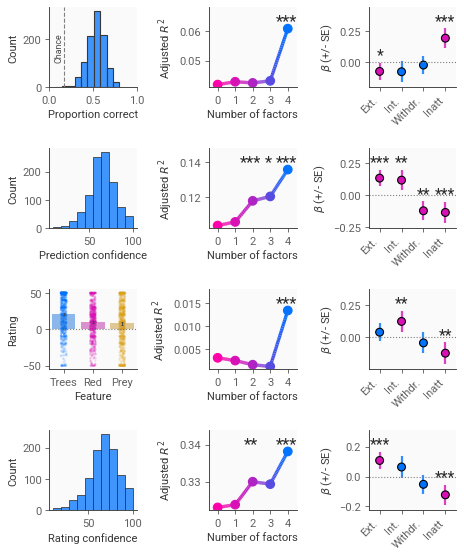

In [39]:
f, ax = plt.subplots(4, 3, figsize=(6, 7))

# ACCURACY

sns.histplot(
    predictions_correct,
    x="Proportion correct",
    fill=True,
    legend=False,
    ax=ax[0, 0],
    bins=10,
)
ax[0, 0].axvline(1 / 6.0, color="gray", linestyle="--")  # Guessing
# Add text next to chance line
ax[0, 0].text(
    1 / 6.0 - 0.005,
    # y should be half of the y-axis range
    (ax[0, 0].get_ylim()[1] - ax[0, 0].get_ylim()[0]) / 2,
    "Chance",
    horizontalalignment="right",
    verticalalignment="center",
    fontsize=8,
    rotation=90,
    alpha=0.9,
)
ax[0, 0].set_xlim(0, 1)
sns.despine()

predictions_correct_model_outputs.y_var = "Prop. correct"
plot_r2s(predictions_correct_model_outputs, ax=ax[0, 1])
# remove title
ax[0, 1].set_title("")

forest_plot(
    predictions_correct_model_outputs.models[4],
    rename_dict=rename_dict,
    ax=ax[0, 2],
    show_xlabel=False,
    exclude_param_names=["age", "gender", "motivation"],
)

# CONFIDENCE IN PREDICTIONS

sns.histplot(
    confidence_summary, x="confidence", fill=True, legend=False, ax=ax[1, 0], bins=10
)
ax[1, 0].set_xlabel("Prediction confidence")
sns.despine()

confidence_model_outputs.y_var = "Confidence"
plot_r2s(confidence_model_outputs, ax=ax[1, 1])
# remove title
ax[1, 1].set_title("")

forest_plot(
    confidence_model_outputs.models[4],
    rename_dict=rename_dict,
    ax=ax[1, 2],
    show_xlabel=False,
    exclude_param_names=["age", "gender", "motivation", "p_correct"],
)

# RATINGS

## Subject predictions
ax[2, 0].axhline(0, color="gray", linestyle=":")
sns.stripplot(
    x="feature",
    y="Rating",
    hue="feature",
    data=rating_df_cleaned[
        (rating_df_cleaned["env"] == 5) & (rating_df_cleaned["feature"] != "Confidence")
    ],
    alpha=0.15,
    ax=ax[2, 0],
    zorder=-1,
    hue_order=["Trees", "Red", "Prey"],
    order=["Trees", "Red", "Prey"],
    legend=False,
    s=2,
)
sns.barplot(
    x="feature",
    y="Rating",
    hue="feature",
    data=rating_df_cleaned[
        (rating_df_cleaned["env"] == 5) & (rating_df_cleaned["feature"] != "Confidence")
    ],
    alpha=0.5,
    capsize=0.05,
    errwidth=0.8,
    ax=ax[2, 0],
    hue_order=["Trees", "Red", "Prey"],
    order=["Trees", "Red", "Prey"],
    dodge=False,
)

sns.despine()

ax[2, 0].legend().set_visible(False)
ax[2, 0].set_xlabel("Feature")

plot_r2s(preference_rating_model_outputs["error_abs"], ax=ax[2, 1])

# remove title
ax[2, 1].set_title("")

forest_plot(
    preference_rating_model_outputs["error_abs"].models[4],
    rename_dict=rename_dict,
    ax=ax[2, 2],
    show_xlabel=False,
    exclude_param_names=["age", "gender", "motivation"],
)

# RATING CONFIDENCE
sns.histplot(
    rating_confidence_mean_df,
    x="confidence_raw",
    fill=True,
    legend=False,
    ax=ax[3, 0],
    bins=10,
)
ax[3, 0].set_xlabel("Rating confidence")
sns.despine()

plot_r2s(preference_rating_model_outputs["confidence"], ax=ax[3, 1])

# remove title
ax[3, 1].set_title("")

forest_plot(
    preference_rating_model_outputs["confidence"].models[4],
    rename_dict=rename_dict,
    ax=ax[3, 2],
    show_xlabel=False,
    exclude_param_names=[
        "age",
        "gender",
        "motivation",
        "error_abs",
        "Rating",
        "Rating2",
    ],
)

# Save
if not os.path.exists("figures/combined"):
    os.makedirs("figures/combined")
plt.savefig("figures/combined/figure3.svg", bbox_inches="tight")
plt.savefig("figures/combined/figure3.pdf", bbox_inches="tight")

## Combine and export tables

Finally we export the tables containing model comparison results and coefficients for use in the manuscript.


### Model comparison results


In [40]:
# Rounding for each column
round_dict = {
    "df_resid": 0,
    "ssr": 2,
    "ss_diff": 2,
    "F": 2,
    "Pr(>F)": 3,
}

# Tidier names for each column
column_rename_dict = {
    "df_resid": "$df_{R}$",
    "ssr": "$SS_{R}$",
    "ss_diff": "$SS_{diff}$",
    "F": "$F$",
    "Pr(>F)": "$p$",
}

# Glossary of terms
terms = "$df_{R}$ = residual degrees of freedom, $SS_{R}$ = residual sum of squares, $SS_{diff}$ = difference in residual sum of squares between models, $F$ = F-statistic, $p$ = p-value."

# Save to markdown
dataframes_to_markdown(
    [
        predictions_correct_model_outputs_anova,
        predictions_rt_model_outputs_anova,
        confidence_model_outputs_anova,
        preference_rating_model_outputs_anova["error_abs"],
        preference_rating_model_outputs_anova["confidence"],
        preference_rating_model_outputs_anova["prey_rating"],
    ],
    [
        f"Model comparison results for models of subjects' predictions of the predator's movements. {terms}",
        f"Model comparison results for models of subjects' reaction times when predicting the predator's movements {terms}",
        f"Model comparison results for models of subjects' confidence in predictions of the predator's movements. {terms}",
        f"Model comparison results for models of subjects' ratings of the predator's preferences. {terms}",
        f"Model comparison results for models of subjects' confidence in ratings of the predator's preferences. {terms}",
        f"Model comparison results for models of subjects' ratings of the predator's preference for the robot character. {terms}",
    ],
    [round_dict] * 6,
    [column_rename_dict] * 6,
    ["Pr(>F)"] * 6,
    "paper/supplementary_tables.md",
    "# Supplementary Tables",
)

Creating or overwriting file: paper/supplementary_tables.md


### Coefficients


In [41]:
# Dictionary to rename variables
coef_rename_dict = {
    "Intercept": "Intercept",
    "age": "Age",
    "gender": "Gender",
    "Rating": "Rating",
    "Rating2": "Rating<sup>2</sup>",
    "p_correct": "Prop. correct",
    "error_abs": "\|Error\|",
    "motivation": "Motivation",
    "Sol4_ML1": "Externalising",
    "Sol4_ML2": "Internalising",
    "Sol4_ML3": "Withdrawal",
    "Sol4_ML4": "Inattention",
}

# List of model outputs
model_outputs = [
    predictions_correct_model_outputs,
    confidence_model_outputs,
    preference_rating_model_outputs["error_abs"],
    preference_rating_model_outputs["confidence"],
]

# Convert coefficient tables to DataFrames
coef_dfs = [
    coefficients_to_dataframe(i, rename_dict=coef_rename_dict) for i in model_outputs
]

# Rounding for coef table
coef_round_dict = {
    "coef": 2,
    "std err": 2,
    "t": 2,
    "P>|t|": 3,
    "[0.025": 2,
    "0.975]": 2,
}

# Rename columns
coef_column_rename_dict = {
    "coef": "$\\beta$",
    "std err": "$\\beta_{SE}$",
    "t": "$t$",
    "P>|t|": "$p$",
    "[0.025": "$CI_{2.5}$",
    "0.975]": "$CI_{97.5}$",
}

# Glossary of terms
terms = "$\\beta$ = regression coefficient, $\\beta_{SE}$ = standard error of regression coefficient, $t$ = t-statistic, $p$ = p-value, $CI_{2.5}$ = 95% confidence interval lower bound, $CI_{97.5}$ = 95% confidence interval upper bound."

# Write to markdown file
dataframes_to_markdown(
    coef_dfs,
    [
        f"Coefficients for winning model of subjects' predictions of the predator's movements. {terms}",
        f"Coefficients for winning model of subjects' confidence in predictions of the predator's movements. {terms}",
        f"Coefficients for winning model of subjects' ratings of the predator's preferences. {terms}",
        f"Coefficients for winning model of subjects' confidence in ratings of the predator's preferences. {terms}",
    ],
    [coef_round_dict] * len(coef_dfs),
    [coef_column_rename_dict] * len(coef_dfs),
    ["P>|t|"] * len(coef_dfs),
    "paper/supplementary_tables.md",
    append=True,
)

Appending to existing file: paper/supplementary_tables.md


### Exploratory models


In [42]:
# Rounding for coef table
# parameter	measure	t	df	p	p_fdr
exp_round_dict = {
    "t": 2,
    "df": 0,
    "p": 3,
    "p_fdr": 3,
}

# Rename columns
exp_column_rename_dict = {
    "parameter": "Parameter",
    "measure": "Measure",
    "t": "$t$",
    "df": "$df$",
    "p": "$p$",
    "p_fdr": "$p_{FDR}$",
}

# Glossary of terms
terms = (
    "$t$ = t-statistic, $df$ = degrees of freedom, $p$ = p-value, $p_{FDR}$ = false discovery rate corrected p-value"
    ", AQ-10 = Autism Spectrum Quotient, STICSA-T = State Trait Inventory of Cognitive and Somatic Anxiety, LSAS = Liebowitz "
    "Social Anxiety Scale, PHQ-8 = Patient Health Questionnaire, GAD-7 = Generalized Anxiety Disorder Assessment"
)

# Dataframes
all_coefs = pd.concat(
    [
        predictions_correct_exploratory,
        confidence_correct_exploratory.replace("confidence", "prediction_confidence"),
        rating_error_exploratory,
        rating_confidence_exploratory,
        prey_rating_exploratory,
    ]
).reset_index(drop=True)
all_coefs["measure"] = all_coefs["measure"].str.replace("_", "-")
all_coefs["parameter"] = all_coefs["parameter"].replace(
    {
        "p_correct": "Prop. correct move predictions",
        "prediction_confidence": "Confidence in move predictions",
        "error_abs": "\|Preference rating error\|",
        "confidence": "Confidence in preference ratings",
        "prey_rating": "Prey rating",
    }
)

# Write to markdown file
dataframes_to_markdown(
    [all_coefs],
    [
        f"Coefficients for additional measures predicting different aspects of behaviour, taken from regression models including the same covariates as the primary models. {terms}",
    ],
    [exp_round_dict],
    [exp_column_rename_dict],
    ["p_fdr"],
    "paper/supplementary_tables.md",
    append=True,
    repeated_value_columns=[['parameter']]
)

parameter Index(['parameter', 'measure', 't', 'df', 'p', 'p_fdr'], dtype='object')
Appending to existing file: paper/supplementary_tables.md
